In [1]:
%load_ext autoreload
%autoreload 2

import torch as t
import numpy as np
import matplotlib.pyplot as plt


In [2]:
data = np.load('datasets/pong1M/frames_mirrored.npy')
print(data.shape)

(1000000, 24, 24, 3)


In [3]:
unique_elements = set([tuple(d.tolist()) for d in data[:5].reshape(-1, 3)])

In [4]:
unique_elements

{(0, 255, 255), (6, 24, 24), (255, 0, 0), (255, 255, 255)}

In [5]:
from src.datasets.pong1m_multi import get_loader

loader, pred2frame = get_loader()

tensor(2997679) tensor(2948362)
103 batches


In [7]:
frames, a = next(iter(loader))

In [12]:
a[2]

tensor([[2, 0],
        [3, 0],
        [2, 0],
        [3, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [3, 0],
        [1, 0],
        [1, 0],
        [2, 0],
        [1, 0],
        [3, 0],
        [1, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [1, 0],
        [3, 0],
        [3, 0],
        [2, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [3, 0],
        [2, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [3, 0],
        [1, 0],
        [2, 0],
        [3, 0],
        [3, 0],
        [3, 0],
        [2, 0],
        [2, 0],
        [2, 0],
        [1, 0],
        [2, 0],
        [2, 0],
        [3, 0],
        [1, 0],
        [1, 0],
        [3, 0],
        [3, 0],
        [2, 0],
        [1, 0],
        [3, 0],
        [2, 0],
        [3, 0],
        [1, 0],
        [3, 0],
        [2, 0],
        [3, 0],
        

In [13]:
frames = pred2frame(frames)
print(frames)

tensor([[[[[127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           ...,
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127]],

          [[127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           ...,
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127]],

          [[127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           ...,
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127],
           [127, 127, 127,  ..., 127, 127, 127]]],


         [[[127, 127, 127,  ..., 127, 127, 127],
           [1

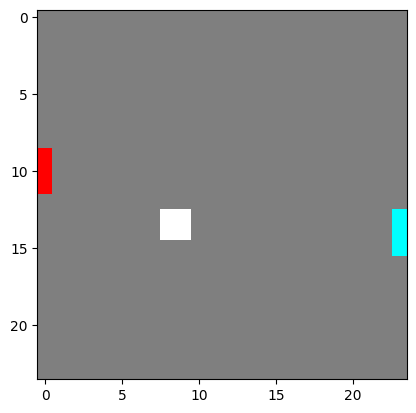

In [14]:
plt.imshow(frames[0, 0].permute(1, 2, 0))
plt.show()

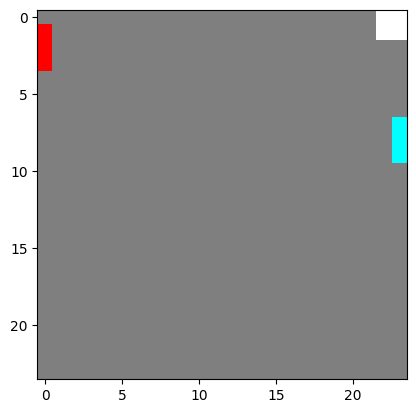

In [15]:
plt.imshow(frames[2, 0].permute(1, 2, 0))
plt.show()

In [ ]:
@torch.amp.autocast('cuda', enabled=False)
def rope_apply(x, grid_sizes, freqs):
    n, c = x.size(2), x.size(3) // 2

    # split freqs
    freqs = freqs.split([c - 2 * (c // 3), c // 3, c // 3], dim=1)

    # loop over samples
    output = []
    for i, (f, h, w) in enumerate(grid_sizes.tolist()):
        seq_len = f * h * w

        # precompute multipliers
        x_i = torch.view_as_complex(x[i, :seq_len].to(torch.float64).reshape(
            seq_len, n, -1, 2))
        freqs_i = torch.cat([
            freqs[0][:f].view(f, 1, 1, -1).expand(f, h, w, -1),
            freqs[1][:h].view(1, h, 1, -1).expand(f, h, w, -1),
            freqs[2][:w].view(1, 1, w, -1).expand(f, h, w, -1)
        ],
                            dim=-1).reshape(seq_len, 1, -1)

        # apply rotary embedding
        x_i = torch.view_as_real(x_i * freqs_i).flatten(2)
        x_i = torch.cat([x_i, x[i, seq_len:]])

        # append to collection
        output.append(x_i)
    return torch.stack(output).float()

In [ ]:
d = dim // num_heads
self.freqs = torch.cat([
    rope_params(1024, d - 4 * (d // 6)),
    rope_params(1024, 2 * (d // 6)),
    rope_params(1024, 2 * (d // 6))
],
                        dim=1)